In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import pickle
from model import LearningMethod, VoNet, names_from_json, init_weights
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import FormatStrFormatter
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from sklearn.metrics import r2_score, mean_squared_error as mse
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from pymatgen.core import Structure
from model import load_data, CustomDataset
import json
import sys
sys.path.append('/home/asar/projects/moxel_pypi/src/')
from moxel import plot_voxels, mic_scale_factors, voxels_from_file

In [2]:
# Disable autograd
torch.set_grad_enabled(False);

# Reproducible results
np.random.seed(1)
torch.manual_seed(1);

#mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['font.size'] = 14

# Dataset MOFs

In [3]:
column_names = [
    'MOFname', 'CO2_uptake_P0.15bar_T298K [mmol/g]',
    'heat_adsorption_CO2_P0.15bar_T298K [kcal/mol]',
    'volume [A^3]', 'weight [u]', 'surface_area [m^2/g]',
    'void_fraction', 'void_volume [cm^3/g]',
    'largest_free_sphere_diameter [A]',
    'largest_included_sphere_along_free_sphere_path_diameter [A]',
    'largest_included_sphere_diameter [A]',
    ]

features = column_names[3:]
target = column_names[1]

df_uo = pd.read_csv('data/all_MOFs_screening_data.csv')
df_uo.set_index('MOFname', inplace=True)

In [4]:
mof_train = names_from_json('data/batches/batch_val_test/clean_names.json')
mof_val_test = names_from_json('data/batches/batch_val_test/clean_names.json')
mof_val = mof_val_test[:5000]
mof_test = mof_val_test[5000:]

In [5]:
df_train = df_uo.loc[mof_train]
df_val = df_uo.loc[mof_val]
df_test = df_uo.loc[mof_test]

for df in [df_uo, df_train, df_val, df_test]:
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)

## Violin plots

In [6]:
y_uo_rf, y_train_rf, y_val_rf, y_test_rf = [df[target].values for df in [df_uo, df_train, df_val, df_test]]

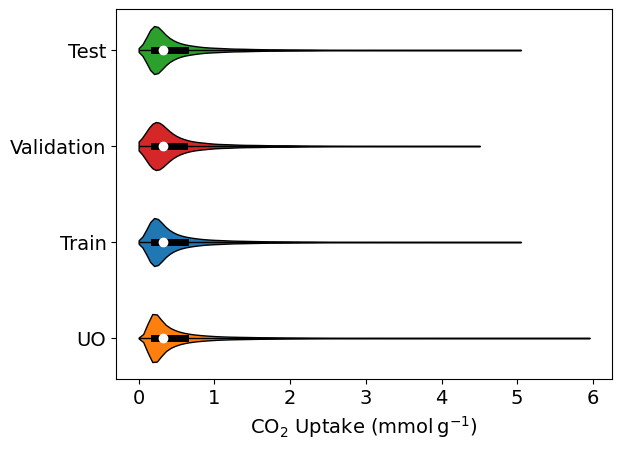

In [23]:
indices = [1, 2, 3, 4]
data = [y_uo_rf, y_train_rf, y_val_rf, y_test_rf]

parts = plt.violinplot(data, showextrema=False, vert=False)
plt.yticks(indices, ['UO', 'Train', 'Validation', 'Test'])
plt.xlabel(r'$\mathrm{CO}_2$ Uptake ($\mathrm{mmol} \, \mathrm{g}^{-1})$')

colors = [f'tab:{c}' for c in ['orange', 'blue', 'red', 'green']]
for b, c in zip(parts['bodies'], colors):
    b.set_facecolor(c)
    b.set_edgecolor('k')
    b.set_linewidth(1)
    b.set_alpha(1)

plt.hlines(indices, [min(val) for val in data], [max(val) for val in data], color='k', linewidth=1)

for index, y in zip(indices, data):
    q1, median, q3 = np.percentile(y, [25, 50, 75])
    plt.plot([q1, q3], [index]*2, color='k', linewidth=5)
    plt.scatter(median, index, color='w', zorder=2,)

plt.savefig('/home/asar/Dropbox/papers/voxels/fig/violin.pdf', bbox_inches='tight')

## Dimensionality reduction with PCA

In [9]:
scaler = StandardScaler()
df_uo = df_uo[df_uo.void_fraction > 0]

X_uo = scaler.fit_transform(df_uo[features])
pca = PCA(n_components=2)

X_transformed = pca.fit_transform(X_uo)

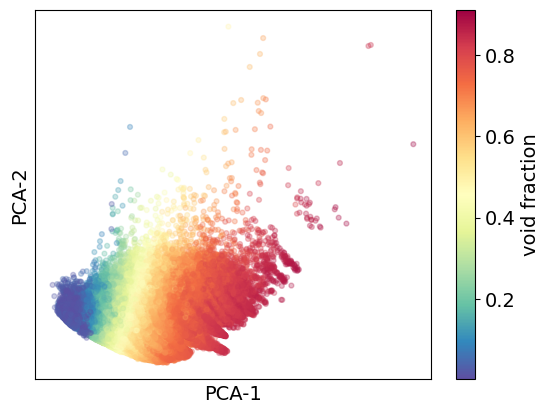

In [24]:
fig, ax = plt.subplots()

im = ax.scatter(X_transformed[:, 0], X_transformed[:, 1], alpha=0.3, s=12, c=df_uo.void_fraction, cmap='Spectral_r')
#ax.set_xlim(-7.5, 15)
#ax.set_ylim(-2.5, 10)
ax.set_xticks([])
ax.set_yticks([])
#ax.axis('off')
ax.set_xlabel('PCA-1')
ax.set_ylabel('PCA-2')
cbar = fig.colorbar(im, label='void fraction')
cbar.solids.set(alpha=1);

plt.savefig('/home/asar/Dropbox/papers/voxels/fig/pca.png', dpi=700)

# Dataset COFs

In [3]:
mof_test = names_from_json('data/COFs/batch_test/clean_names.json')

In [4]:
df = pd.read_csv('data/COFs/COFs_low_pressure.csv')
df.set_index('COFname', inplace=True)

In [5]:
df_test = df.loc[mof_test]
features = ['dompore', 'maxpore', 'voidfraction', 'gsurface', 'density']
target = 'adsV_CH4_5.8b'

In [6]:
X_test = df_test.loc[:, features]
y_test = df_test.loc[:, target]

# Random Forest models

In [7]:
# Confidence interval by bootstrap sampling the test set
def ci_bs_sample(y_true, y_pred, metric_fn, n=1000):
    choices = range(len(y_true))
    
    metric_values = []
    for i in range(n):
        indices = np.random.choice(choices, size=len(choices))
        y_true_bs = y_true[indices]
        y_pred_bs = y_pred[indices]
        metric = metric_fn(y_true_bs, y_pred_bs)
        
        metric_values.append(metric)
        
    q25, q975 = np.quantile(metric_values, [0.025, 0.975])
    mean = sum(metric_values)/len(metric_values)
    
    return metric_values, mean, q25, q975

In [8]:
def parity_plot_with_ci(
    y_true, y_pred, metric_fn, title, ci=True, n=1000,
    metric_label='$R^2$', color='C0', hist=False,
    hist2d_args={}, diagonal_args={}, hist_args={}, hist_leg_args={}
    ):
    
    if ci:
        fig = plt.figure(layout='constrained', figsize=[5, 6])
        subfigs = fig.subfigures(2, 1, wspace=0.37, height_ratios=[2, 1])
        ax_top = subfigs[0].subplots()
        ax_bottom = subfigs[1].subplots()
    else:
        fig = plt.figure()
        ax_top = plt.gca()
    
    metric = metric_fn(y_test, y_pred)
    
    if hist:
        ax_top.hist2d(
            y_true, y_pred, bins=400,
            norm=mpl.colors.LogNorm(),
            label='', **hist2d_args
        )
    else:
        ax_top.scatter(y_true, y_pred, s=2, alpha=0.2, color=color)
    
    ax_top.set_xlabel('Ground truth')
    ax_top.set_ylabel('ML prediction')
    ax_top.set_xlim(0, max(y_true))
    ax_top.set_ylim(0, max(y_true))
    ax_top.plot([0, 1], [0, 1], transform=ax_top.transAxes, color='k', lw=0.7, **diagonal_args)
    ax_top.set_title(title)
    
    ax_top.text(
        0.05, 0.9, rf'{metric_label} = {metric:.3f}',
        bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.5'),
        transform=ax_top.transAxes, fontsize=11
    )
    
    if ci:
        trans = mpl.transforms.blended_transform_factory(ax_bottom.transData, ax_bottom.transAxes)
        metric_values, mean, q25, q975 = ci_bs_sample(y_true, y_pred, metric_fn=metric_fn, n=n)
        ax_bottom.hist(metric_values, color=color, bins=30, alpha=0.2, **hist_args)
        ax_bottom.vlines(
            [q25, q975], ymin=[0]*2, ymax=[1]*2, 
            color=color, transform=trans, ls='--', 
            label=f'95% CI = [{q25:.3f}, {q975:.3f}]'
        )
        ax_bottom.vlines(
            mean, ymin=0, ymax=1, 
            color=color, transform=trans, 
            label=f'Mean {metric_label} = {mean:.3f}'
        )
        ax_bottom.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
        ax_bottom.set_xlabel(f'{metric_label}')
        ax_bottom.set_ylabel('Count')
        ax_bottom.legend(**hist_leg_args)
        
    return fig

In [9]:
# Loading the Random Forest model trained with geometric features
#with open('saved_models/COFs/rf_geom_55871.pkl', 'rb') as fhand:
#    rf_geom = pickle.load(fhand)

# Loading the Random Forest model trained with geometric + energetic features
with open('saved_models/rf_geom.pkl', 'rb') as fhand:
    rf_geom = pickle.load(fhand)

In [10]:
# Getting the inputs
X_test_geom = df_test[features]

In [11]:
# Getting the predictions
y_pred_geom = rf_geom.predict(X_test_geom)

## Parity plots

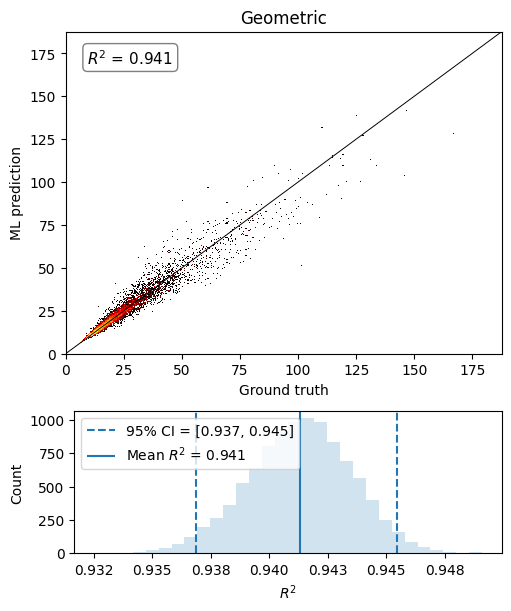

In [45]:
# Parity plot for geometric features
parity_geom = parity_plot_with_ci(
    y_test, y_pred_geom, r2_score,
    hist=True,
    #ci=False,
    n=10_000,
    color='C0',
    title='Geometric',
    hist2d_args=dict(cmap='hot'),
    #hist_leg_args=dict(loc='upper left')
)
plt.savefig('/home/asar/Dropbox/tex/presentations/cnn/fig/parity_geom_cofs.pdf')

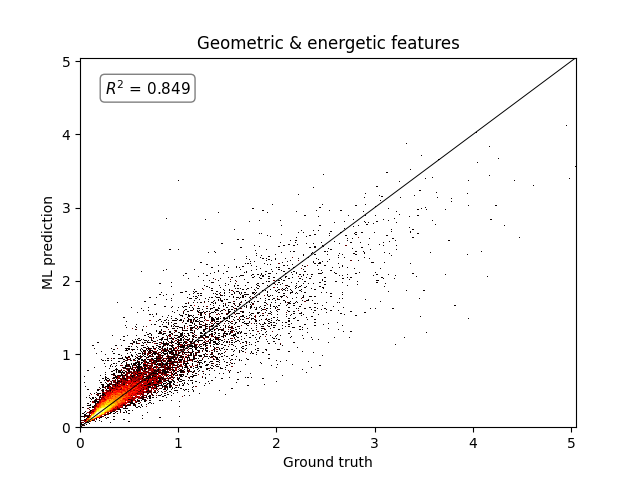

In [204]:
# Parity plot for geometric & energetic features
parity_geom_en = parity_plot_with_ci(
    y_test_rf, y_pred_geom_en, r2_score,
    hist=True,
    ci=False,
    n=10_000,
    color='C1',
    title='Geometric & energetic features',
    hist_args=dict(cmap='hot')
)
plt.show()
#plt.savefig('fig/parity_geom_en.pdf')

# CNN model

In [27]:
def saliency_map(x, model):
    # Freeze model parameters and set it for inference
    model.requires_grad_(False)
    model.eval()
    
    x = torch.tensor(x, requires_grad=True, device='cuda')
    out = model(x)
    out.backward()
    
    return x.grad

In [20]:
# Load train data
#X_train, y_train = load_data(
#        'data/batches/batch_train',
#        'data/all_MOFs_screening_data.csv',
#        'CO2_uptake_P0.15bar_T298K [mmol/g]',
#        'MOFname',
#        )
#
## Load validation and test data
#X_val_test, y_val_test = load_data(
#        'data/batches/batch_val_test',
#        'data/all_MOFs_screening_data.csv',
#        'CO2_uptake_P0.15bar_T298K [mmol/g]',
#        'MOFname',
#        )

X_train, y_train = load_data(
        'data/COFs/batch_train',
        'data/COFs/COFs_low_pressure.csv',
        'adsV_CH4_5.8b',
        'COFname',
        )

X_test, y_test = load_data(
        'data/COFs/batch_test',
        'data/COFs/COFs_low_pressure.csv',
        'adsV_CH4_5.8b',
        'COFname',
        )

#X_test, y_test = X_val_test[5000:], y_val_test[5000:]
#X_val, y_val = X_val_test[:5000], y_val_test[:5000]
#
X_test = X_test.reshape(X_test.shape[0], 1, *X_test.shape[1:])
#X_val = X_val.reshape(X_val.shape[0], 1, *X_val.shape[1:])

standardization = transforms.Normalize(X_train.mean(), X_train.std())

#test_loader = DataLoader(
#        CustomDataset(X=X_test, y=y_test, transform_X=standardization),
#        batch_size=512, pin_memory=True
#        )
test_loader = DataLoader(
        CustomDataset(X=X_test, y=y_test, transform_X=standardization),
        batch_size=512, pin_memory=True
        )
#val_loader = DataLoader(
#        CustomDataset(X=X_val, y=y_val, transform_X=standardization),
#        batch_size=512, pin_memory=True
#        )

In [21]:
# Predictions of CNN model on test set
def model_predictions(model, data_loader, device='cuda'):
    device = torch.device(device)
    model.net.eval()

    predictions = []
    for x, _ in data_loader:
        y_pred = model.predict(x.to(device))
        predictions.append(y_pred)

    y_pred = torch.concatenate([b for b in predictions])
    y_pred = y_pred.cpu().numpy()
    
    return y_pred

In [105]:
#with open('saved_models/with_data_augmentation/VoNet_32432.pkl', 'rb') as fhand:
#    model = pickle.load(fhand)

with open('saved_models/COFs/with_data_augmentation/VoNet_55871.pkl', 'rb') as fhand:
    model = pickle.load(fhand)

## Inkscape

In [30]:
mof = torch.from_numpy(np.load('data/IRMOF-1.npy')).reshape(1, 1, 25, 25, 25).to('cuda')

In [31]:
out = model.net.conv1(mof).cpu().detach().numpy()

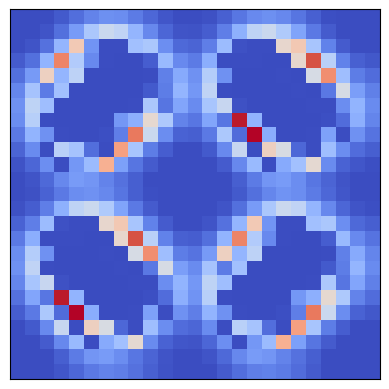

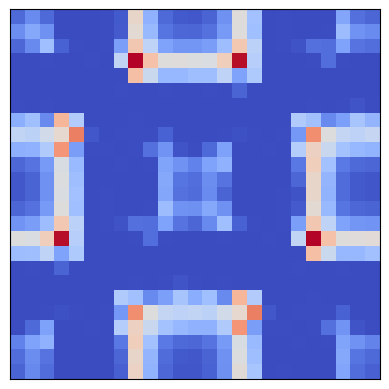

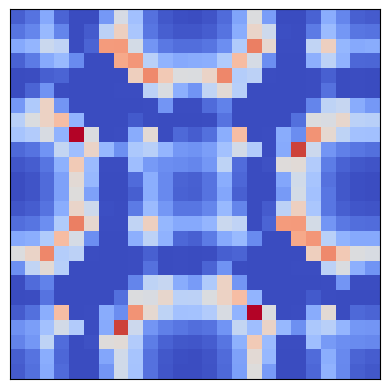

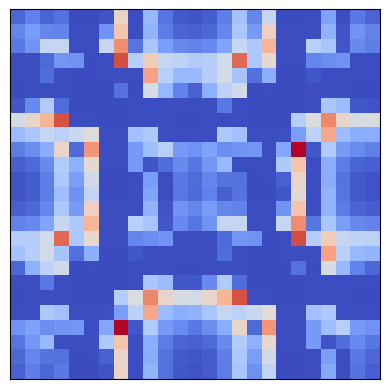

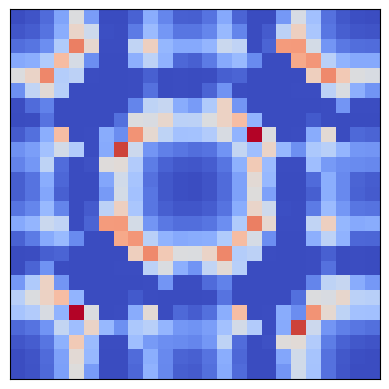

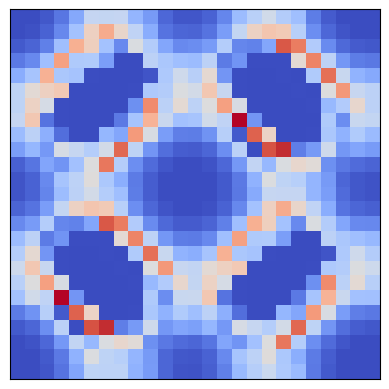

In [40]:
for i in [0, 8, 9, 15, 21, 22]:
    plt.imshow(out[0, 11, i], cmap='coolwarm')
    plt.xticks([])
    plt.yticks([])
    plt.savefig(f'../../Dropbox/tex/presentations/cnn/fig/slice_{i}.png', bbox_inches='tight', pad_inches=0)
    plt.show()

## Data augmentation

In [2]:
train_size = [5_000, 10_000, 15_000, 20_000, 32_432]
data_augmentation = ['wo', 'with']
data_aug_results = {'wo': {}, 'with': {}}

#for exp in data_augmentation:
#    for size in train_size:
#        with open(f'saved_models/{exp}_data_augmentation/VoNet_{size}.pkl', 'rb') as fhand:
#            model = pickle.load(fhand)
#            y_pred = model_predictions(model, test_loader)
#            data_aug_results[exp][size] = ci_bs_sample(y_test, y_pred, metric_fn=r2_score)[1:]

In [3]:
with open('results/data_augmentation.json', 'r') as fhand:
    data_aug_results = json.load(fhand)

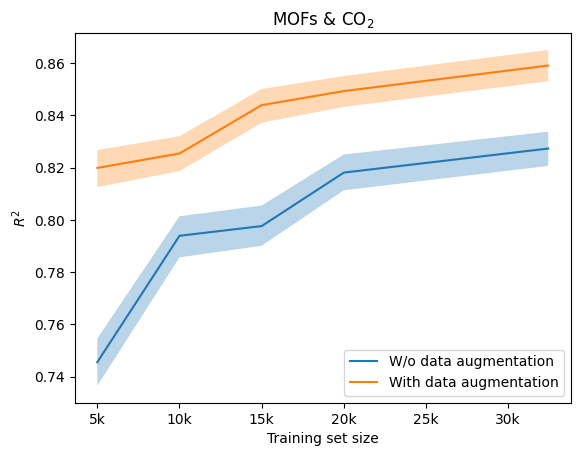

In [6]:
fig, ax = plt.subplots()

for exp in data_augmentation:
    exp_res = np.array([data_aug_results[exp][str(size)] for size in train_size])
    mean, q25, q975 = exp_res.T
    
    dq25 = mean - q25
    dq975 = q975 - mean
    
    flag = 'With' if exp == 'with' else 'W/o'
    ax.plot(train_size, mean, label=f'{flag} data augmentation')
    ax.fill_between(train_size, mean-dq25, mean+dq975, alpha=0.3)
    
ax.set_title(r'MOFs & $\mathsf{CO_2}$')
ax.set_ylabel(r'$R^2$')
ax.set_xlabel('Training set size')
ax.legend(loc='lower right')
    
#ax.set_xscale('log')
ax.set_xticks(np.arange(5_000, 35_000, 5_000), ['5k', '10k', '15k', '20k', '25k', '30k']);
plt.savefig('/home/asar/Dropbox/tex/presentations/cnn/fig/data_augmentation.pdf')

## Learning curves

In [29]:
#train_size = [100, 500, 1_000, 2_000, 5_000, 10_000, 15_000, 20_000, 35_000, 55_871]
#train_size = [5_000, 10_000, 20_000, 35_000, 55_871]
train_size = [100, 500, 1_000, 2_000, 5_000, 10_000, 15_000, 20_000, 32_432]
mode = ['voxels', 'geom']
#learning_results = {'voxels': {}, 'geom': {}}
#
#model_path, model_name = 'saved_models/COFs/with_data_augmentation/', 'VoNet'
#
#for x_type in mode:
#    if x_type == 'geom': model_path, model_name = 'saved_models/COFs/', 'rf_geom'
#    
#    for size in train_size:
#        with open(f'{model_path}{model_name}_{size}.pkl', 'rb') as fhand:
#            model = pickle.load(fhand)
#            
#            if x_type == 'voxels':
#                y_pred = model_predictions(model, test_loader)
#                y_true = y_test
#            else:
#                y_pred = model.predict(X_test_geom)
#                #y_true = y_test_rf
#                
#            learning_results[x_type][size] = ci_bs_sample(y_true, y_pred, metric_fn=r2_score)[1:]

In [4]:
#with open('results/COFs/learning_curves.json', 'w') as fhand:
#    learning_results = json.dump(learning_results, fhand, indent=4)

In [30]:
with open('results/MOFs/learning_curves.json', 'r') as fhand:
    learning_results = json.load(fhand)

### In linear scale

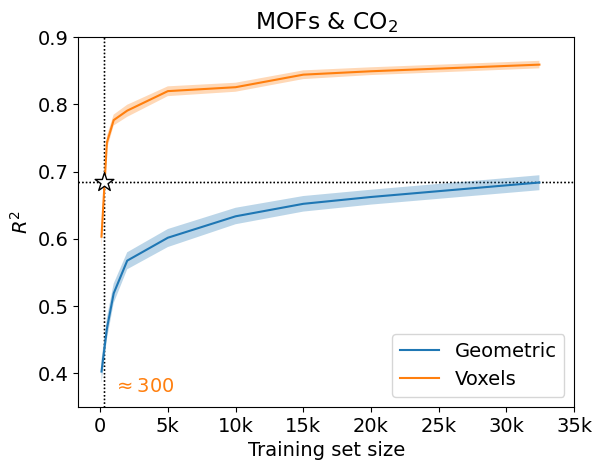

In [32]:
fig, ax = plt.subplots()

for x_type in mode[::-1]:
    x_type_res = np.array([learning_results[x_type][str(size)] for size in train_size])
    mean, q25, q975 = x_type_res.T
    
    dq25 = mean - q25
    dq975 = q975 - mean
    
    label = 'Voxels' if x_type == 'voxels' else 'Geometric'
    ax.plot(train_size, mean, markerfacecolor='white', label=label)
    ax.fill_between(train_size, mean-dq25, mean+dq975, alpha=0.3)
    ax.set_ylabel(r'$R^2$')
    ax.set_xlabel('Training set size')
ax.legend(loc='lower right')
    
trans_v = mpl.transforms.blended_transform_factory(ax.transData, ax.transAxes)
trans_h = mpl.transforms.blended_transform_factory(ax.transAxes, ax.transData)

# MOFs
ax.hlines(learning_results['geom']['32432'][0], 0, 1, transform=trans_h, colors='black', lw=1, ls=':', zorder=-1); 
ax.vlines(250, 0, 1, transform=trans_v, colors='black', lw=1, ls=':', zorder=-1);

ax.hlines(learning_results['geom']['32432'][0], 0, 1, transform=trans_h, colors='black', lw=1, ls=':', zorder=-1); 
ax.vlines(300, 0, 1, transform=trans_v, colors='black', lw=1, ls=':', zorder=-1);
ax.scatter(300, learning_results['geom']['32432'][0], marker='*', c='white', edgecolors='black', s=200, zorder=10)
ax.text(0.07, 0.04, r'$\approx$300', c='C1', transform=ax.transAxes)

ax.set_xticks(range(0, 40_000, 5_000), ['0',  '5k', '10k', '15k', '20k', '25k', '30k', '35k']);
ax.set_ylim(0.35, 0.90)
ax.set_title(r'MOFs & $\mathrm{CO_2}$');

plt.savefig('/home/asar/Dropbox/papers/voxels/fig/learning_curves_mofs.pdf')

# COFs
#ax.hlines(learning_results['geom']['55871'][0], 0, 1, transform=trans_h, colors='black', lw=1, ls=':', zorder=-1); 
#ax.vlines(6900, 0, 1, transform=trans_v, colors='black', lw=1, ls=':', zorder=-1);
#
#ax.scatter(6900, learning_results['geom']['55871'][0], marker='*', c='white', edgecolors='black', s=200, zorder=10)
#ax.text(0.18, 0.04, r'$\approx$6.9k', c='C1', transform=ax.transAxes)
#
##ax.set_xticks(range(5_000, 65_000, 5_0000), ['0',  '5k', '10k', '15k', '20k', '25k', '30k', '35k']);
#ax.set_ylim(0.91, 0.98)
#ax.set_xticks([0, 10_000, 20_000, 30_000, 40_000, 50_000, 60_000], ['0', '10k', '20k', '30k', '40k', '50k', '60k'])
##ax.set_xlim(0, 60_000)
#ax.set_title(r'COFs & $\mathrm{CH_4}$');
#
#plt.savefig('/home/asar/Dropbox/papers/voxels/fig/learning_curves_cofs.pdf')

## Performance metrics

In [11]:
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse

In [12]:
mode = ['voxels', 'geom']
model_path, model_name = 'with_data_augmentation/', 'VoNet'

for x_type in mode:
    print(f'Performance metrics for {x_type}:\n')
    
    if x_type == 'geom': model_path, model_name = '', 'rf_geom'
    
    with open(f'saved_models/{model_path}{model_name}_32432.pkl', 'rb') as fhand:
        model = pickle.load(fhand)

    if x_type == 'voxels':
        y_pred = model_predictions(model, test_loader)
        y_true = y_test
    else:
        y_pred = model.predict(X_test_geom)
        y_true = y_test_rf

    for metric_name, metric in zip(['R2', 'MAE', 'MSE'], [r2_score, mae, mse]):
        metric_value = ci_bs_sample(y_true, y_pred, metric_fn=metric)[1:]
        print(f'{metric_name}: {metric_value}')

Performance metrics for voxels:

R2: (0.8590933563449834, 0.8532789353170666, 0.8645889694992286)
MAE: (0.11597294612973928, 0.11409207247197628, 0.11787355989217758)
MSE: (0.039219573706388476, 0.03768861535936594, 0.04082919741049409)
Performance metrics for geom:

R2: (0.6837982936887864, 0.6723170105986866, 0.6940258736771165)
MAE: (0.16865372171062434, 0.16589449631076703, 0.1715224136005442)
MSE: (0.08776254226655673, 0.08403935587224362, 0.09173793493425379)


## Saliency map

In [106]:
# Get the gradient
mof = np.load('data/IRMOF-1.npy').reshape(1, 1, 25, 25, 25)
grad = abs(saliency_map(mof, model.net).detach().cpu().numpy().reshape(25, 25, 25))

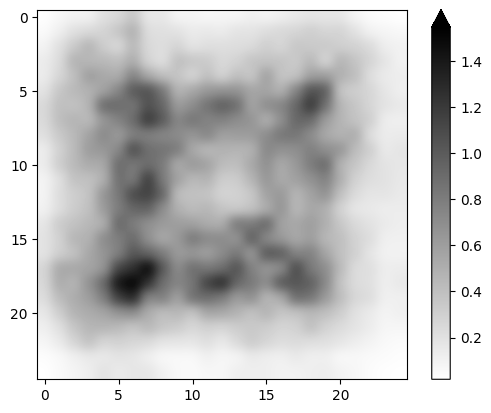

In [118]:
plt.imshow(grad.sum(axis=2), interpolation='gaussian', cmap='binary')
plt.colorbar(extend='max')
#plt.savefig('/home/asar/Dropbox/tex/presentations/master_pres/fig/saliency_map_cofs.pdf', bbox_inches='tight', pad_inches=0)

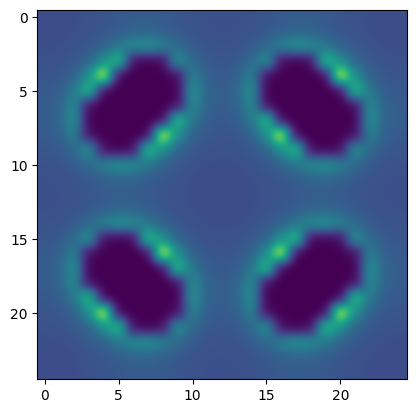

In [14]:
plt.imshow(mof[0, 0, 0], interpolation='gaussian')

## Parity plot

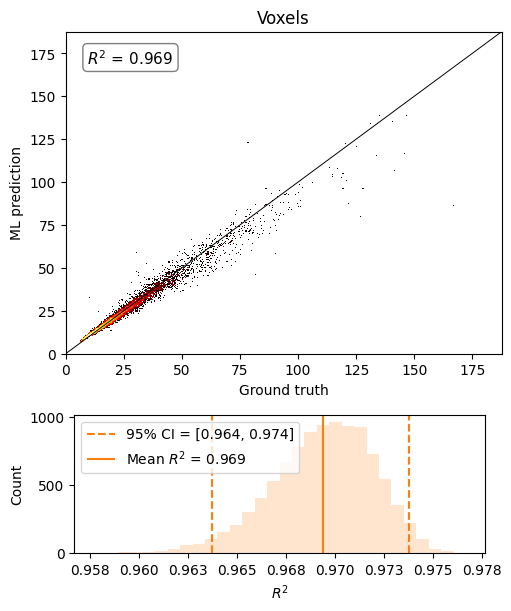

In [44]:
# Parity plot for voxels
y_pred = model_predictions(model, test_loader)

parity_voxels = parity_plot_with_ci(
    y_test, y_pred.reshape(-1), r2_score,
    hist=True,
    #ci=False,
    n=10_000,
    color='C1',
    title='Voxels',
    hist2d_args=dict(cmap='hot')
)
#plt.savefig('/home/asar/Dropbox/tex/presentations/cnn/fig/parity_voxels_cofs.pdf')

## Visualizing some convolutional kernels from the first layer

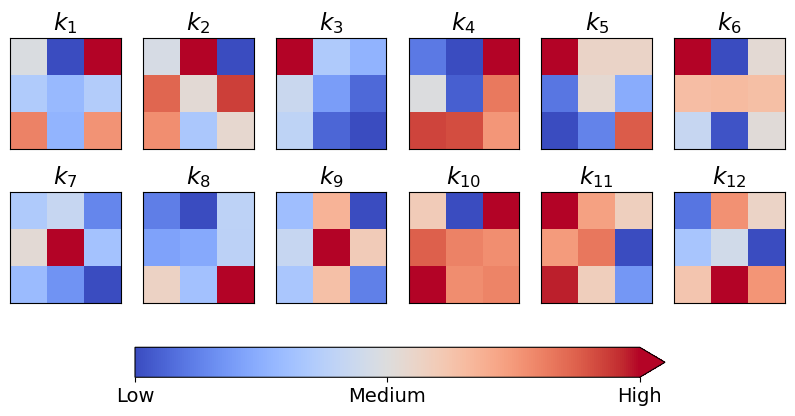

In [11]:
params = [w for w in model.net.parameters()]
kernels_l1 = params[0]

kernel_shape = np.array(kernels_l1[0, 0].shape)

inp_shape = np.array([25, 25, 25])
out_shape = inp_shape - kernel_shape + 1

fig, axes = plt.subplots(nrows=2, ncols=6, figsize=[10, 6])
fig.subplots_adjust(hspace=-0.5, wspace=0.2)

slc = 0
for i, ax in enumerate(axes.flatten(), start=1):
    im = ax.imshow(kernels_l1[i-1, 0, slc].cpu().numpy(), cmap='coolwarm')#, interpolation='gaussian')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(rf'$k_{{{i}}}$')
    
cax = fig.add_axes([0.25, 0.15, 0.53, 0.05])
cbar = fig.colorbar(mpl.cm.ScalarMappable(cmap='coolwarm'), cax=cax, extend='max', orientation='horizontal')
cbar.set_ticks([0, 0.5, 1])
cbar.set_ticklabels(['Low', 'Medium', 'High'])
#fig.suptitle(f'Slice[{slc}] from the Conv1 filters', y=0.92, fontsize=18);
 # plt.savefig('fig/kernel.pdf')

## Visualizing forward-pass of IRMOF-1

In [2]:
mof = np.load('data/IRMOF-1.npy')
inp = torch.tensor(mof).to('cuda').reshape(1, 1, 25, 25, 25)

/home/asar/venvir/cuda/lib64/python3.11/site-packages/torch/nn/modules/conv.py:597: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv3d(


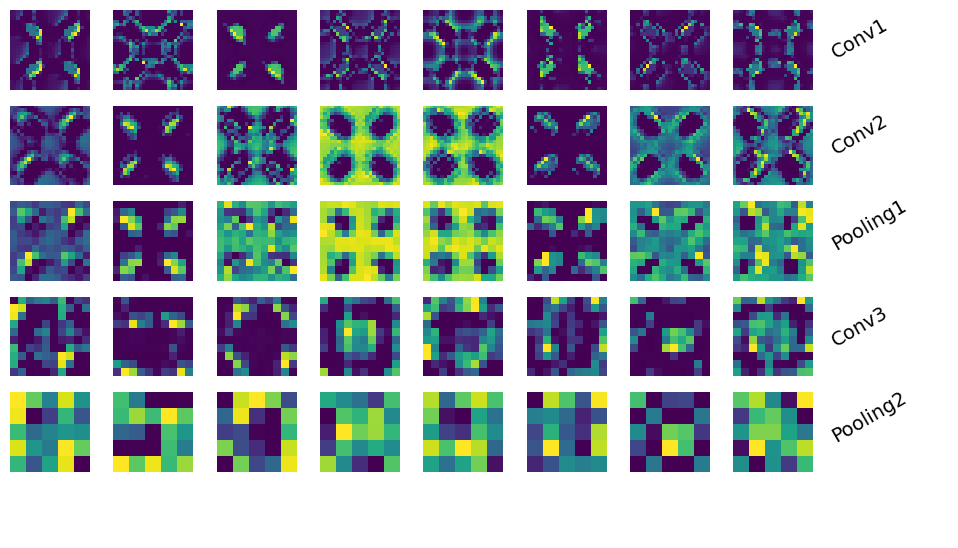

In [6]:
# Showing input
cmap = 'viridis'

fig, axes = plt.subplots(5, 8, figsize=[12, 6])
fig.subplots_adjust(hspace=0.2, wspace=-0.5)
axes = axes.flatten()

# Showing Conv1
out_conv1 = model.net.conv1(inp)
for i, ax in enumerate(axes[:8]):
    ax.axis('off')
    ax.imshow(out_conv1.cpu().numpy()[0, i, 10], cmap=cmap)

# Showing Conv2
out_conv2 = model.net.conv2(out_conv1)
for i, ax in enumerate(axes[8:16]):
    ax.axis('off')
    ax.imshow(out_conv2.cpu().numpy()[0, i, 10], cmap=cmap)

# Showing Max1
out_max1 = model.net.max1(out_conv2)
for i, ax in enumerate(axes[16:24]):
    ax.axis('off')
    ax.imshow(out_max1.cpu().numpy()[0, i, 5], cmap=cmap)

# Show Conv3
out_conv3 = model.net.conv3(out_max1)
for i, ax in enumerate(axes[24:32]):
    ax.axis('off')
    ax.imshow(out_conv3.cpu().numpy()[0, i, 0], cmap=cmap)

# Show Max2
out_max2 = model.net.max2(out_conv3)
for i, ax in enumerate(axes[32:40]):
    ax.axis('off')
    ax.imshow(out_max2.cpu().numpy()[0, i, 0], cmap=cmap)

labels = ['Conv1', 'Conv2', 'Pooling1', 'Conv3', 'Pooling2']

ax_txt = fig.add_axes((0.86, 0.0, 0.1, 0.8))
ax_txt.axis('off')

for i, l in enumerate(labels[::-1], start=1):
    ax_txt.text(0, 0.2*i, l, rotation=30, transform=ax_txt.transAxes)
#plt.savefig('/home/asar/Dropbox/tex/presentations/master_pres/fig/foo.pdf', bbox_inches=0, pad_inches=0)
plt.savefig('/home/asar/Dropbox/tex/presentations/master_pres/fig/forward.pdf', bbox_inches=0, pad_inches=0)

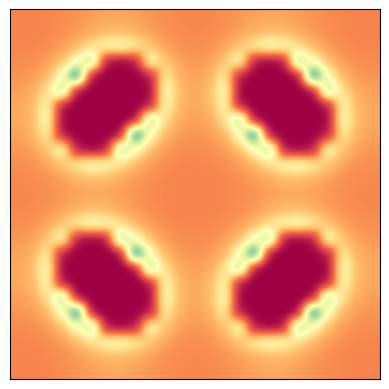

In [22]:
for i in range(25):
    plt.xticks([])
    plt.yticks([])
    plt.imshow(mof[i], interpolation='gaussian', cmap='Spectral')
    plt.savefig(f'fig/workflow/irmof-1_{i}.png', pad_inches=0, transparent=True, bbox_inches='tight')

## Random initialization of Conv1 layer

In [184]:
with open('saved_models/VoNet.pkl', 'rb') as fhand:
    model = pickle.load(fhand)

In [185]:
conv1 = next(model.net.conv1.parameters())
old_weights = conv1.data.detach().clone()

In [192]:
model.net.eval()
device = torch.device('cuda')
results = {s: [] for s in range(1, 13)}
rep_per_size = 100

for n in range(rep_per_size):
    
    # Selecting which filters will be initialized
    for drop_size in range(1, 13):
        mask = np.random.choice(range(12), size=drop_size, replace=False)
        
        for index in mask:
            conv1.data[index] = torch.nn.init.kaiming_normal(conv1.data[index])
            
        predictions = []
        for x, _ in val_loader:
            y_pred = model.predict(x.to(device))
            predictions.append(y_pred)

        y_pred = torch.concatenate([b for b in predictions])
        y_pred = y_pred.reshape(-1).cpu().numpy()

        r2 = r2_score(y_val, y_pred)
        results[drop_size].append(r2)
        
        # Restore initial values
        conv1.data = old_weights
        

In [202]:
with open('drop_filters,json', 'r') as fhand:
    results = json.load(fhand)

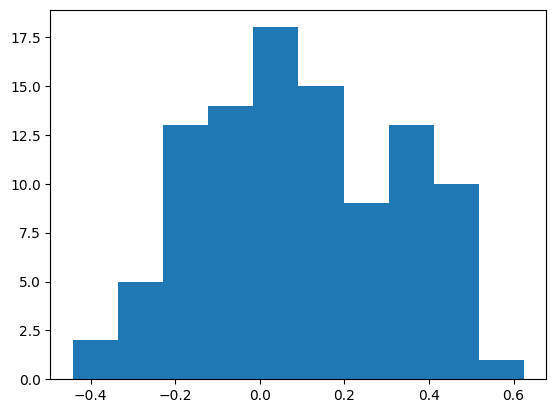

In [207]:
values = results['1']
plt.hist(values)
plt.show()

## Visualizing learning curves of the model

ValueError: x and y must have same first dimension, but have shapes (1,) and (50,)

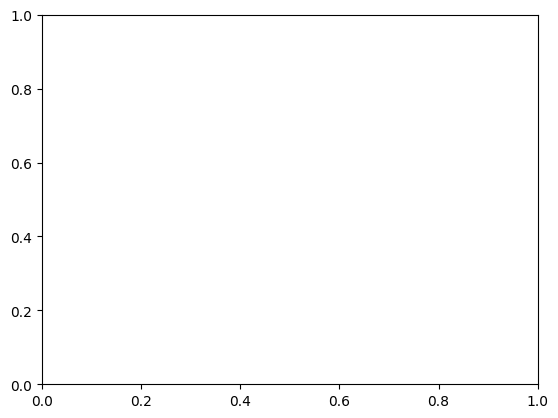

In [4]:
fig, ax = plt.subplots()
#axin = ax.inset_axes([0.3, 0.3, 0.67, 0.67])

# Plotting on the main axis
for loss in [model.train_hist, model.val_hist]:
    ax.plot(model.epochs, loss)

#ax.set_xscale('log')
ax.set_xlabel('Epoch')
ax.set_ylabel(r'$R^2$')

# Plotting on the inset axis
#for loss in [model.train_hist, model.val_hist]:
    #axin.plot(epochs, loss)

#axin.set_xlabel('Epoch');
#axin.set_ylabel('MSE');
#axin.set_ylim((0, 0.2));
#axin.legend(['Train loss', 'Validation loss']);

#ax.indicate_inset_zoom(axin);
# # plt.savefig('fig/learning_curve.pdf')

In [15]:
model.train_batch_size
len(model.train_hist)
model.n_iter_loss

15

## Finding input that maximizes output

In [47]:
model.net.requires_grad_(False);

In [48]:
x = torch.nn.Parameter(torch.randn((1, 1, 25, 25, 25), device='cuda'))
optim = torch.optim.SGD([x], lr=1e-3, weight_decay=10)
mse = torch.nn.MSELoss()
y = torch.tensor([[200.0]], device='cuda')

In [49]:
model.net.eval()
for _ in range(500):
    y_pred = model.net(x)
    loss = mse(y_pred, y)
    loss.backward()
    optim.step()
    optim.zero_grad()

## Predict property of proposed structure and visualize it

In [50]:
new_y = model.predict(x)
print(f'Predicted property for proposed structure: {new_y}')
new_mof = x.reshape(25, 25, 25).detach().cpu().numpy()

Predicted property for proposed structure: tensor([[107.7012]], device='cuda:0')


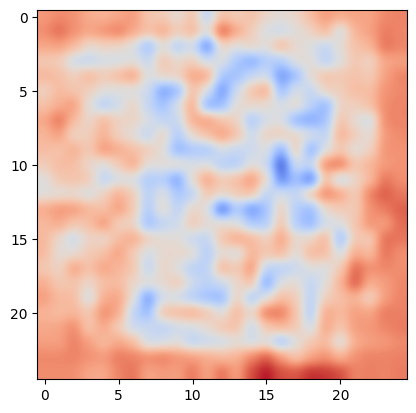

In [51]:
plt.imshow(new_mof.sum(axis=0), cmap='coolwarm', interpolation='gaussian')

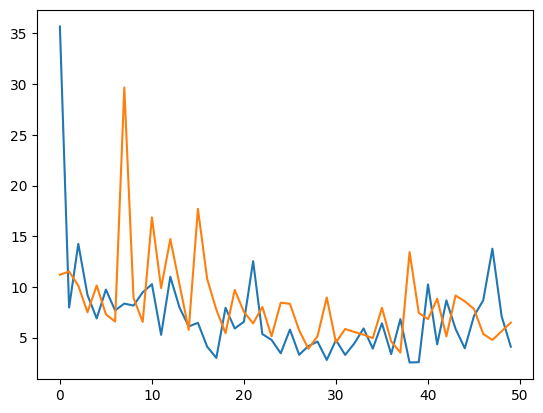

In [52]:
plt.plot(model.train_hist)
plt.plot(model.val_hist)

In [23]:
fig.gca().axis('off')
fig.savefig('/home/asar/Dropbox/tex/presentations/master_pres/fig/irmof-1_voxels.png', dpi=300, bbox_inches='tight', pad_inches=0)